In [1]:
from torch.nn import Sequential
from torch.nn import Linear, Dropout, ReLU
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import MSELoss, HuberLoss
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import json
import os

from Module.MySQL_connector import MySQLConnector
from Module.feature_selector_tree import feature_selector
import optuna
import logging
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss

c:\Users\Nico\anaconda3\envs\dev310-mldl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_table = pd.read_json("../../data/processed/example_pricing.json")

In [3]:
raw_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,0.130702,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,8.404149,0.453316,0.587113,0.466248,0.207158,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,8.404149,0.453316,0.587113,0.466248,0.261404,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,8.404149,0.453316,0.587113,0.466248,0.303481,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,8.404149,0.453316,0.587113,0.466248,0.337860,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.404149,0.453316,0.587113,0.466248,0.862623,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
96,8.404149,0.453316,0.587113,0.466248,0.864557,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
97,8.404149,0.453316,0.587113,0.466248,0.866472,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
98,8.404149,0.453316,0.587113,0.466248,0.868367,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [5]:
from sklearn.model_selection import train_test_split

def load_dataset(raw_table, batch_size, tree_depth):
    # full_table = feature_selector(raw_table,tree_depth)
    full_table = raw_table
    X_full = full_table.drop(columns="sales").values
    Y_full = full_table['sales'].values
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 42)

    X_train_full = np.array(X_train_full, dtype=np.float32)
    y_train_full = np.array(y_train_full, dtype=np.float32)
    X_test_full = np.array(X_test_full, dtype=np.float32)
    y_test_full = np.array(y_test_full, dtype=np.float32)

    x_train, y_train = torch.tensor(X_train_full), torch.tensor(y_train_full)
    x_test, y_test = torch.tensor(X_test_full), torch.tensor(y_test_full)
    x_train = x_train.to(torch.float32)
    x_test = x_test.to(torch.float32)
    y_train = y_train.to(torch.float32)
    y_test = y_test.to(torch.float32)
    # 將PyTorch tensor 製作成 Data Loader
    td = TensorDataset(x_train, y_train)
    dl_train = DataLoader(td, batch_size=batch_size, shuffle=True)
    # Shuffle 隨機打亂數據，防止模型過度依賴數據的順序，從而提高模型的泛化能力。
    td = TensorDataset(x_test, y_test)
    dl_test = DataLoader(td, batch_size=batch_size, shuffle=False)
    input_size=X_full.shape[1]
    return dl_train, dl_test, input_size

In [6]:
def create_model(hidden_layers, hidden_units, dropout_rate, input_size):
    layers = [ 
        nn.Linear(input_size, 1024),  # 輸入層
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=dropout_rate),  # 使用可調整的 dropout rate
    ]

    # 動態添加隱藏層
    in_features = 1024
    for _ in range(hidden_layers):
        layers.append(nn.Linear(in_features, hidden_units))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_units))
        layers.append(nn.Dropout(p=dropout_rate))
        in_features = hidden_units

    # 輸出層
    layers.append(nn.Linear(in_features, 1))
    
    return nn.Sequential(*layers)

In [10]:
# 加載模型權重
best_para = {'hidden_layers': 1, 
             'hidden_units': 320, 
             'dropout_rate': 0.8450569460998046, 
             'learning_rate': 0.005221932445598954, 
             'tree_depth': 13
        }
weight_decay = 0.00024797053276969004
batch_size = 512
hidden_layers = best_para["hidden_layers"]
hidden_units = best_para["hidden_units"]
dropout_rate = best_para["dropout_rate"]
learning_rate = best_para["learning_rate"]
tree_depth = best_para["tree_depth"]

model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate, input_size=487)
model.load_state_dict(torch.load("../../data/processed/DNN_model_for_pricing"))
model.to("cuda:0")
model.eval()  # 設置模型為推理模式

C:\Users\Nico\AppData\Local\Temp\ipykernel_20968\731890985.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../data/processed/DNN_mo

Sequential(
  (0): Linear(in_features=487, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.8450569460998046, inplace=False)
  (4): Linear(in_features=1024, out_features=320, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.8450569460998046, inplace=False)
  (8): Linear(in_features=320, out_features=1, bias=True)
)

In [ ]:
import torch
import pandas as pd



model.eval()  # 設定為評估模式
features = torch.tensor(raw_table.drop(columns="sales").values, dtype=torch.float32).to("cuda:0")

# 預測 sales
with torch.no_grad():  # 禁用梯度計算
    predictions = model(features)

# 將結果轉為 numpy 格式或直接顯示
# 將結果移動到 CPU 並轉為 numpy 格式
predicted_sales = predictions.cpu().numpy()
print(predicted_sales)


[[6.2050676]
 [6.125417 ]
 [6.067818 ]
 [6.0202847]
 [5.978752 ]
 [5.9434533]
 [5.912978 ]
 [5.8850193]
 [5.859296 ]
 [5.836048 ]
 [5.813693 ]
 [5.793201 ]
 [5.7746077]
 [5.757431 ]
 [5.7413673]
 [5.726277 ]
 [5.7120495]
 [5.698591 ]
 [5.6858244]
 [5.6736794]
 [5.6621   ]
 [5.651035 ]
 [5.6404715]
 [5.63035  ]
 [5.6206813]
 [5.6119494]
 [5.603633 ]
 [5.595639 ]
 [5.587949 ]
 [5.580511 ]
 [5.5732837]
 [5.5663233]
 [5.5597034]
 [5.5532775]
 [5.5470324]
 [5.5409575]
 [5.5350466]
 [5.5292873]
 [5.523569 ]
 [5.517942 ]
 [5.51242  ]
 [5.5070286]
 [5.5017576]
 [5.496688 ]
 [5.491937 ]
 [5.4872885]
 [5.4826975]
 [5.4781647]
 [5.473724 ]
 [5.46937  ]
 [5.465114 ]
 [5.4609437]
 [5.456851 ]
 [5.4528337]
 [5.448889 ]
 [5.4451327]
 [5.441448 ]
 [5.437834 ]
 [5.4342914]
 [5.430816 ]
 [5.4273973]
 [5.424033 ]
 [5.420722 ]
 [5.4174614]
 [5.4142513]
 [5.41109  ]
 [5.4079776]
 [5.4049187]
 [5.401903 ]
 [5.398931 ]
 [5.395973 ]
 [5.392989 ]
 [5.390046 ]
 [5.387142 ]
 [5.384277 ]
 [5.3814487]
 [5.3786573]

In [ ]:
price = raw_table["price"].values
x = np.expm1(price*5.30325516)
# 將預測結果移到 CPU 並轉換為 numpy 格式
predicted_sales_log = predictions.cpu().numpy()

# 根據您使用的對數底數進行反對數運算
# 如果是自然對數（底數為 e）
predicted_sales = np.expm1(predicted_sales_log)
key_value_pairs = {x[i]: predicted_sales[i][0] for i in range(100)}

In [15]:
key_value_pairs = {x[i]: predicted_sales[i][0] for i in range(100)}
key_value_pairs

{1.000000000365588: 494.25244,
 2.0000000002359095: 456.33548,
 2.9999999993410515: 430.73767,
 4.000000001090242: 410.69577,
 5.000000001568585: 393.94724,
 6.000000001262648: 380.24924,
 7.000000000144455: 368.80588,
 8.000000001415458: 358.6097,
 8.999999998705167: 349.47726,
 9.999999997355195: 341.42346,
 10.99999999896679: 333.8535,
 12.000000001641281: 327.06146,
 12.999999997659861: 321.01807,
 13.99999999649539: 315.53412,
 15.000000003213621: 310.49002,
 16.00000000116457: 305.8248,
 16.99999999657535: 301.4904,
 17.99999999988812: 297.44666,
 19.00000000106622: 293.66068,
 20.000000005439315: 290.10364,
 20.999999998731855: 286.75223,
 22.000000003398817: 283.58582,
 23.000000002320654: 280.59546,
 23.99999999764428: 277.7597,
 24.999999994246735: 275.0774,
 26.00000000636957: 272.67725,
 27.000000000437954: 270.41064,
 27.999999994542343: 268.2497,
 28.99999999847461: 266.187,
 30.00000000419878: 264.20712,
 30.99999999530624: 262.29727,
 31.99999999466059: 260.47098,
 33.0

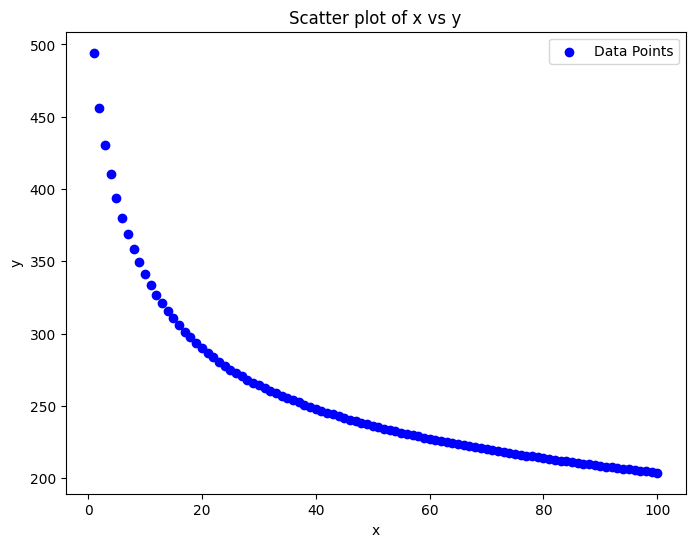

In [18]:
import matplotlib.pyplot as plt

# 繪製 x 和 y 的散佈圖
x_values = list(key_value_pairs.keys())
y_values = list(key_value_pairs.values())

# 繪製 x 和 y 的散佈圖
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, color='blue', label='Data Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of x vs y')
plt.legend()
plt.show()